In [2]:
# import requests

# url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
# output_path = "sam_vit_b_01ec64.pth"

# print("Downloading SAM model...")

# with requests.get(url, stream=True) as r:
#     r.raise_for_status()
#     with open(output_path, "wb") as f:
#         for chunk in r.iter_content(chunk_size=8192):
#             f.write(chunk)

# print("Download complete.")


Generating masks with SAM...
Found 67 regions.


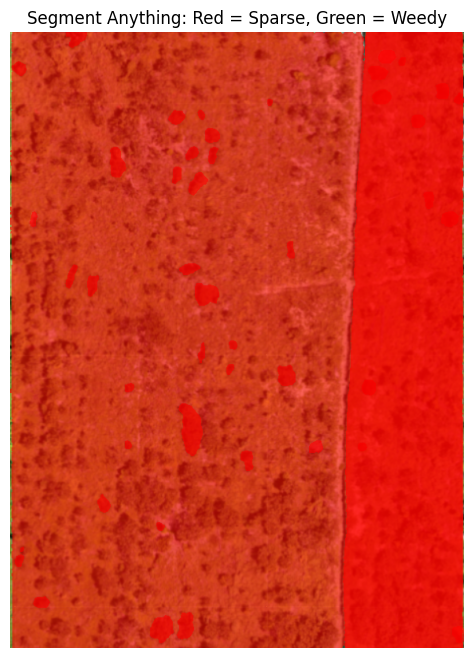

In [5]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load SAM model
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

# Create mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

# Load and prepare image
image_path = "./data/low.png"
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise FileNotFoundError("Image not found.")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Generate masks
print("Generating masks with SAM...")
masks = mask_generator.generate(image_rgb)
print(f"Found {len(masks)} regions.")

# Optional: visualize masks as overlay
overlay = image_rgb.copy()

def apply_mask(image, mask, color):
    image[mask] = (np.array(color) * 0.6 + image[mask] * 0.4).astype(np.uint8)

# Filter and color masks
for m in masks:
    seg = m["segmentation"]
    avg_color = np.mean(image_rgb[seg], axis=0)
    green_ratio = avg_color[1] / (avg_color[0] + avg_color[2] + 1e-5)

    if green_ratio < 0.8:
        apply_mask(overlay, seg, [255, 0, 0])   # Sparse - red
    elif green_ratio > 1.3 and np.sum(seg) > 1000:
        apply_mask(overlay, seg, [0, 255, 0])   # Overgrown - green

# Show result
plt.figure(figsize=(12, 8))
plt.imshow(overlay)
plt.title("Segment Anything: Red = Sparse, Green = Weedy")
plt.axis("off")
plt.show()


Generating masks...
67 masks found.


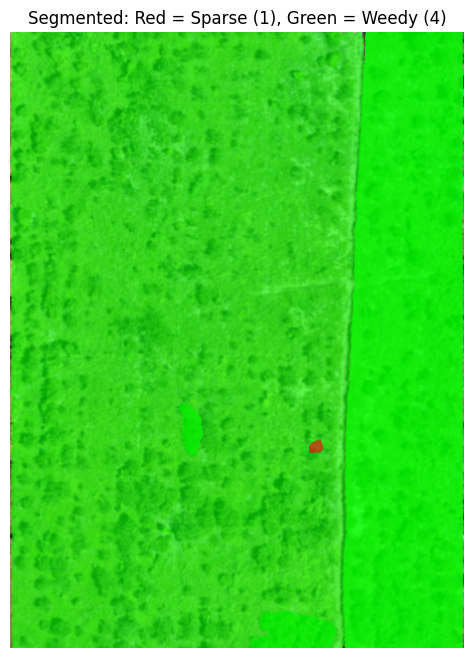

In [6]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load SAM model
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

# Create mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

# Load image
image_path = "./data/low.png"
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise FileNotFoundError("Image not found.")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Generate masks
print("Generating masks...")
masks = mask_generator.generate(image_rgb)
print(f"{len(masks)} masks found.")

# Vegetation classification using Excess Green (ExG)
def compute_exg(region_rgb):
    R = region_rgb[:, 0].astype(np.float32)
    G = region_rgb[:, 1].astype(np.float32)
    B = region_rgb[:, 2].astype(np.float32)
    return np.mean(2 * G - R - B)

# Apply masks
overlay = image_rgb.copy()

def apply_mask(image, mask, color):
    image[mask] = (np.array(color) * 0.6 + image[mask] * 0.4).astype(np.uint8)

sparse_count, weedy_count = 0, 0

for m in masks:
    mask = m["segmentation"]
    pixels = image_rgb[mask]
    if len(pixels) == 0:
        continue
    exg = compute_exg(pixels)
    area = np.sum(mask)

    if exg < 20:  # sparse or bare areas
        apply_mask(overlay, mask, [255, 0, 0])  # Red
        sparse_count += 1
    elif exg > 50 and area > 1000:  # very green + big area = weedy
        apply_mask(overlay, mask, [0, 255, 0])  # Green
        weedy_count += 1

# Show
plt.figure(figsize=(12, 8))
plt.imshow(overlay)
plt.title(f"Segmented: Red = Sparse ({sparse_count}), Green = Weedy ({weedy_count})")
plt.axis("off")
plt.show()


Generating masks...
Generated 37 masks


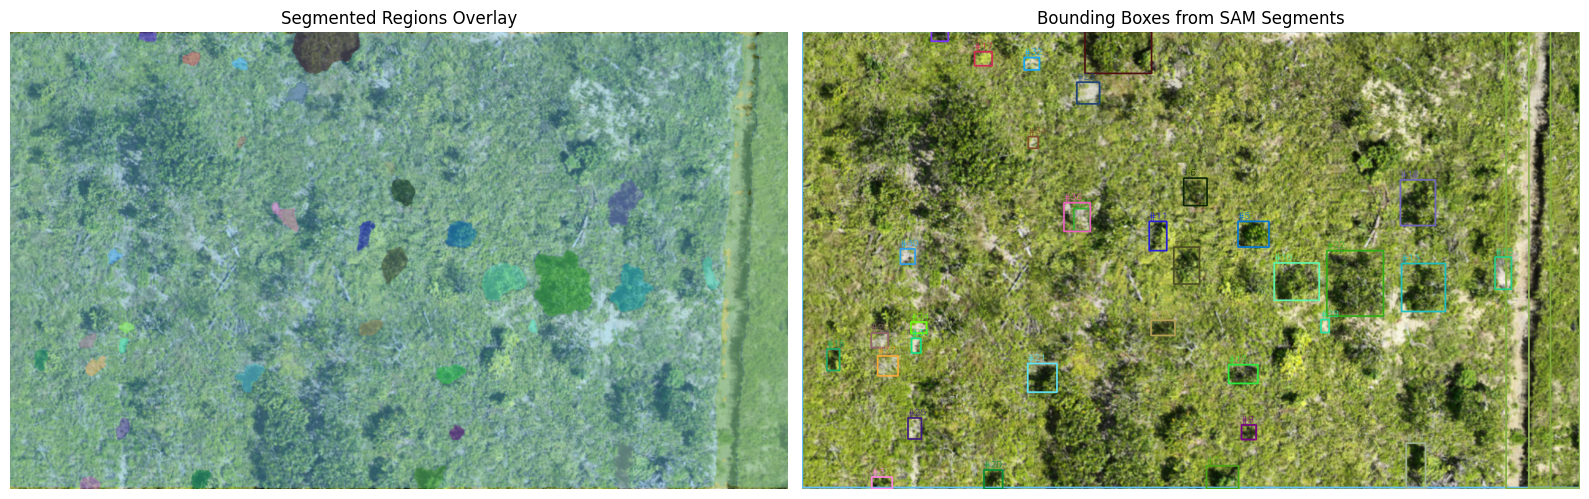

In [19]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load SAM model
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

# Create mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

# Load image
image_path = "./data/high.png"
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise FileNotFoundError("Image not found.")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Generate masks
print("Generating masks...")
masks = mask_generator.generate(image_rgb)
print(f"Generated {len(masks)} masks")

# Prepare images for overlay
overlay = image_rgb.copy()
boxed = image_rgb.copy()

for i, m in enumerate(masks):
    segmentation = m["segmentation"]  # boolean mask

    # Generate random color per mask for visualization
    color = np.random.randint(0, 256, size=3, dtype=np.uint8)

    # Blend the mask color onto the overlay (semi-transparent)
    overlay[segmentation] = (
        0.6 * overlay[segmentation].astype(np.float32) + 0.4 * color
    ).astype(np.uint8)

    # Draw bounding box around the mask
    bbox = m["bbox"]  # [x, y, w, h]
    x, y, w, h = map(int, bbox)
    cv2.rectangle(boxed, (x, y), (x + w, y + h), color.tolist(), 2)
    cv2.putText(boxed, f"#{i}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)

# Show results
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(overlay)
ax[0].set_title("Segmented Regions Overlay")
ax[1].imshow(boxed)
ax[1].set_title("Bounding Boxes from SAM Segments")
for a in ax:
    a.axis("off")
plt.tight_layout()
plt.show()
